In the previous set of tutorials, we saw how to perform frequentist neural simulation-based inference (NSBI) by using neural networks to learn likelihood ratios. We saw that we had to work hard to make sure that the neural networks learned the right thing; if we didn't have enough training data, or if we made poor decisions in how we trained the networks, our inference wouldn't be trustworthy.

In this tutorial, we'll see how we can use ensembles of models to make this process more robust. Recall from the previous tutorial that the cross section for the whole process as a function of $\mu$ can be written as:

$$
\sigma = \mu \sigma_\text{S} + \sqrt{\mu} \sigma_{\text{I}} + \sigma_\text{B}
$$

and that
$$
\frac{p_{\text{SBI}}(x|\mu)}{p_\text{B}(x)} = \frac{(\mu - \sqrt{\mu})\sigma_\text{S} r_\text{S}(x) + \sqrt{\mu} \sigma_\text{SBI} r_\text{SBI}(x) + (1 - \sqrt{\mu})\sigma_\text{B}}{\mu \sigma_\text{S} + \sqrt{\mu} \sigma_\text{I} + \sigma_\text{B}}
$$

For this tutorial, then, we'll use the same neural network estimator for $r_\text{SBI}$ that you trained in the previous tutorial, and we'll play around with using ensembles to model $r_\text{S}$. In order to accelerate training (since we'll need to train an ensemble of networks instead of just two) and make sure that our networks do poorly enough that the effect of ensembling is visible, we'll just use a subset of the data this time (we'll take $100\text{k}$ signal and background events).

We'll also use substantially smaller networks, both because we're using less data (so a huge model is overkill) and because we care less about performance of the individual models for the purposes of this tutorial.

First, let's load in the data.

In [1]:
import sys
import os
run_dir = os.getcwd()
sys.path.append(run_dir)
from physics.simulation import mcfm
from datasets.balanced import BalancedDataModule
from models.carl import CARL_wifi
from models.carl import CARL
from nsbi.carl.utils import load_results_wifi
from nsbi.carl.utils import load_results
from torch.utils.data import TensorDataset, DataLoader
import lightning as L
import torch
import pickle
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

train_data_dir = "/global/cfs/cdirs/trn016/wifi_data/"
numerator_file = train_data_dir + 'sig_small.csv'
denominator_file = train_data_dir + 'bkg_small.csv'

# make sure the features are loaded in as observables (i.e. kinematics)
features = ["l1_pt", "l1_eta", "l1_phi", "l1_energy", "l2_pt", "l2_eta", "l2_phi", "l2_energy", "l3_pt", "l3_eta", "l3_phi", "l3_energy", "l4_pt", "l4_eta", "l4_phi", "l4_energy"]
events_n = mcfm.from_csv(file_path=numerator_file, kinematics=features)
events_d = mcfm.from_csv(file_path=denominator_file, kinematics=features)

Now, we'll use lightning to train an ensemble of models. The basic idea of ensembling is motivated by the fact that training a neural network is a noisy process; you'll get different results every time due to stochasticity in the training data, in the network initialization, and in the training procedure itself. You can reduce this noisiness just by repeating the whole training procedure a bunch of times and averaging the resulting networks, rather than just training once and using the output directly.

There are lots of ways to do this in detail, but we'll use the following ensembling methodology:
$$
\log r_\text{S}(x) = \sum_{i=1}^M w_i f_i(x),
$$
where the $f_i(x)$ are $M$ individual networks trained to estimate $\log r_\text{S}(x)$, the $w_i$ are the weights of each of these networks in the ensemble, and we average the logarithms of the ratios rather than the ratios themselves to avoid trivial but annoying difficulties with negative ratios. We'll start by considering ensembles where we just take a naive average, with $w_i = 1/M$ for all $i$. 

Then, we'll show how the $w_i$ can be learned from data; we'll find that this improves performance relative to the naive average, and it also gives a natural notion of uncertainty due to network deficiencies in the NSBI procedure. This portion will be based on our recent work, 2506.00113.

For our ensembles, we'll train $16$ models, which will hopefully be enough to see an improvement! The only trick in the training here is that we bootstrap resample the dataset each time, so all of our models are trained on slightly different subsets of the training data. Intuitively, this helps the different trainings to capture some of the variation over draws of the training data (without actually having to generate new training data each time).

Feel free to run this, or use the included pretrained networks.

In [2]:
train_own_net = False
if train_own_net:
    ensemble_size = 16
    seeds = range(ensemble_size)
    for seed in seeds:
        L.pytorch.seed_everything(seed)
        events_n_i = events_n.resample(random_state=seed)
        events_d_i = events_d.resample(random_state=seed)

        ds_balanced = BalancedDataModule(numerator_events=events_n_i, denominator_events=events_d_i, features=features, batch_size=1024, random_state=42)
        model_carl = CARL_wifi(n_features=len(features), n_layers=3, n_nodes=64, learning_rate=1e-3)
        trainer = L.Trainer(accelerator='gpu', deterministic=True, default_root_dir=run_dir)

        trainer.fit(
            model=model_carl,
            datamodule=ds_balanced
        )


First, let's get a baseline without ensembling. To do this, we'll load in one of the trained models, and check whether we get sensible inference results.

Depending on your Python version and environment, loading in the models may take some finessing. The load_results_wifi function loads all of the models we just trained at once, the load_results function loads in the SBI network you trained in the previous tutorial, and the code below starting with sbi_state_dict shows how you can do this manually if lightning is not cooperating.

In [3]:
_, _, scaler_sig_over_bkg, models_sig_over_bkg = load_results_wifi("/global/cfs/cdirs/trn016/wifi_models", run_name="carl_wifi")

sbi_state_dict = torch.load("/global/cfs/cdirs/trn016/wifi_models/lightning_logs/version_0/checkpoints/epoch=76-train_loss=0.69.ckpt", map_location=torch.device('cpu'))
model_sbi_over_bkg = CARL(n_features=16, n_layers=16, n_nodes=1024, learning_rate=1e-5)
model_sbi_over_bkg.load_state_dict(sbi_state_dict['state_dict'])
with open("/global/cfs/cdirs/trn016/wifi_models/scaler.pkl", 'rb') as f:
    scaler_sbi_over_bkg = pickle.load(f)

/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Now, we'll pretty much just repeat the analysis of 4_nsbi_measurement.ipynb from the previous tutorial, but using our new (worse) $r_\text{S}$.

In [4]:
lumi = 300.0  # ifb
events_obs = pd.read_csv('/global/cfs/cdirs/trn016/wifi_data/obs_data/mu_x.csv')

features = ['l1_pt', 'l1_eta', 'l1_phi', 'l1_energy', 'l2_pt', 'l2_eta', 'l2_phi', 'l2_energy', 'l3_pt', 'l3_eta', 'l3_phi', 'l3_energy', 'l4_pt', 'l4_eta', 'l4_phi', 'l4_energy']
events_obs_features = events_obs[features]

events_obs_n        = events_obs['n']  # Why is this not always 1 for each entry? See note!

with open('/global/cfs/cdirs/trn016/wifi_data/xsecs/ggzz4l_xs.json', 'r') as f:
    xs = json.load(f)  # fb
    xs_sig_sm = np.prod(xs['sig'])
    xs_bkg_sm = np.prod(xs['bkg'])
    xs_int_sm = np.prod(xs['int'])
    xs_sbi_sm = np.prod(xs['sbi'])

nu_sig_sm = xs_sig_sm * lumi
nu_bkg_sm = xs_bkg_sm * lumi
nu_int_sm = xs_int_sm * lumi
nu_sbi_sm = xs_sbi_sm * lumi

mu_space = torch.linspace(0.0, 4.0, 401)

nu_sig_mu = nu_sig_sm * mu_space
nu_int_mu = nu_int_sm * torch.sqrt(mu_space)
nu_bkg_sm = nu_bkg_sm
nu_sbi_mu = nu_sig_mu + nu_int_mu + nu_bkg_sm

In [5]:
def neg_log_pois(n_obs, nu_exp):
    """
    Evaluates the negative log-likelihood for a Poisson process.
    """
    return nu_exp - n_obs * torch.log(nu_exp)

# IMPLEMENT ME
t_rate = neg_log_pois(events_obs_n.sum(), nu_sbi_mu)

<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_716592/2656653731.py:11: SyntaxWarning: invalid escape sequence '\h'
  plt.scatter(mu_fit.cpu(), 0.0, color='red', label=f'$\hat{{\mu}} = {mu_fit:.2f}$')
/tmp/ipykernel_716592/2656653731.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.scatter(mu_fit.cpu(), 0.0, color='red', label=f'$\hat{{\mu}} = {mu_fit:.2f}$')
/tmp/ipykernel_716592/2656653731.py:13: SyntaxWarn

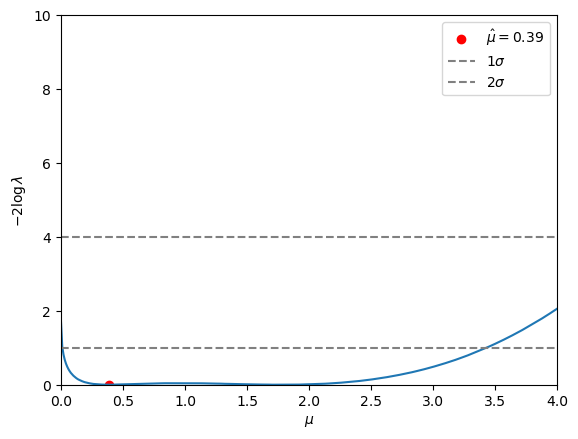

In [6]:
def plot_nll(mu_space, t):
    
    t_min = torch.min(t)
    t -= t_min

    mu_fit = mu_space[torch.argmin(t)]

    plt.plot(mu_space.cpu(), t.cpu())
    plt.xlim(0, 4)
    plt.ylim(0, 10)
    plt.scatter(mu_fit.cpu(), 0.0, color='red', label=f'$\hat{{\mu}} = {mu_fit:.2f}$')

    plt.hlines(1.0, 0, 4,color='gray', linestyle='--', label='$1\sigma$')
    plt.hlines(4.0, 0, 4,color='gray', linestyle='--', label='$2\sigma$')

    plt.xlabel('$\mu$')
    plt.ylabel('$-2 \log \lambda$')

    plt.legend()
    
    plt.show()

plot_nll(mu_space, t_rate)

In [7]:
model_sig_over_bkg = models_sig_over_bkg[0]  # just use the first model in the ensemble as a baseline
X_sig_over_bkg_sm = scaler_sig_over_bkg.transform(events_obs_features.to_numpy())
X_sbi_over_bkg_sm = scaler_sbi_over_bkg.transform(events_obs_features.to_numpy())

dl_sig_over_bkg_sm = DataLoader(TensorDataset(torch.tensor(X_sig_over_bkg_sm, dtype=torch.float32)), batch_size=1024) 
dl_sbi_over_bkg_sm = DataLoader(TensorDataset(torch.tensor(X_sbi_over_bkg_sm, dtype=torch.float32)), batch_size=1024) 

trainer = L.Trainer(accelerator='gpu', devices=1)
s_sig_over_bkg_sm = torch.cat(trainer.predict(model_sig_over_bkg, dl_sig_over_bkg_sm))
s_sbi_over_bkg_sm = torch.cat(trainer.predict(model_sbi_over_bkg, dl_sbi_over_bkg_sm))

r_sig_over_bkg_sm = s_sig_over_bkg_sm / (1 - s_sig_over_bkg_sm)
r_sbi_over_bkg_sm = s_sbi_over_bkg_sm / (1 - s_sbi_over_bkg_sm)

/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/common/software/trn016/python_envs/ml4fp2025 ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with oth

Predicting DataLoader 0: 100%|██████████| 563/563 [00:03<00:00, 176.86it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:05<00:00, 102.84it/s]


In [8]:
multiplier_sig = mu_space - torch.sqrt(mu_space)
multiplier_sbi = torch.sqrt(mu_space)
multiplier_bkg = 1 - torch.sqrt(mu_space)

r_sbi_over_bkg_mu = ( xs_sig_sm * multiplier_sig[None,:] * r_sig_over_bkg_sm[:,None] + xs_sbi_sm * multiplier_sbi[None,:] * r_sbi_over_bkg_sm[:,None] + xs_bkg_sm * multiplier_bkg[None,:] ) / (xs_sig_sm * mu_space + xs_int_sm * torch.sqrt(mu_space) + xs_bkg_sm)

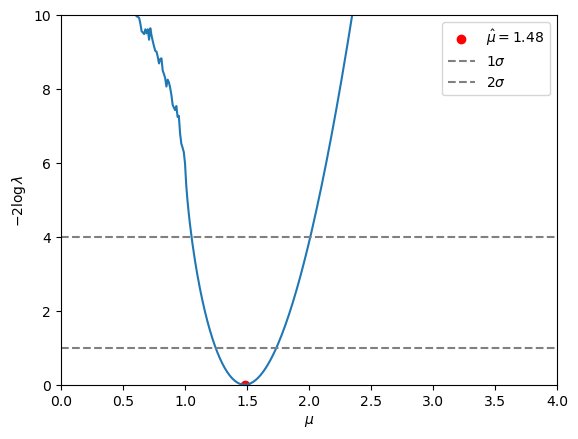

In [9]:
t_shape = -2 * torch.nansum(torch.tensor(events_obs_n)[:,None] * torch.log(r_sbi_over_bkg_mu), dim=0) # need to use nansum here because our model is so bad that it breaks things

plot_nll(mu_space, t_shape)

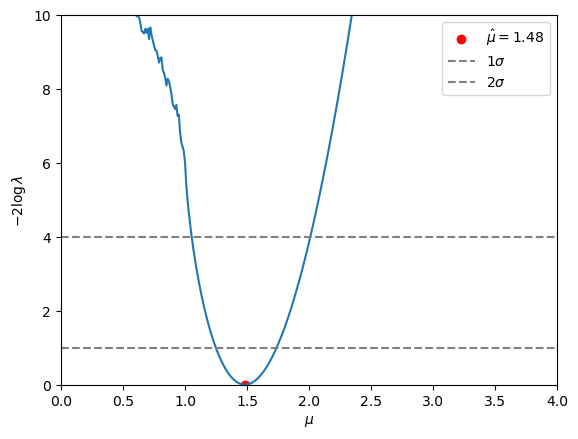

In [10]:
t = t_rate + t_shape
plot_nll(mu_space, t)

And we can see, both from the total incompatibility with the results of the previous tutorial and from the numerical errors, that this is not working at all. We're rejecting the true value of $\mu$ (which is at 0.4). Let's try ensembling! First, we'll use the naive ensemble where we compute the log-likelihoods from each model and just take a simple average.

In [11]:
s_sig_over_bkg_list = []
for model_sig_over_bkg in models_sig_over_bkg:
    s_sig_over_bkg_sm = torch.cat(trainer.predict(model_sig_over_bkg, dl_sig_over_bkg_sm))
    s_sig_over_bkg_list.append(s_sig_over_bkg_sm)

s_sig_over_bkg_tensor = torch.stack(s_sig_over_bkg_list, dim=0)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 220.21it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 198.30it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 197.85it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 207.66it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 205.18it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 221.17it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 202.52it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 208.68it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 201.96it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 206.89it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 225.96it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 207.85it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 202.79it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 201.53it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 220.87it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 563/563 [00:02<00:00, 200.42it/s]


In [12]:
eps = 1e-7  # to avoid numerical issues with dividing by zero here
r_sig_over_bkg_tensor = s_sig_over_bkg_tensor/(1-s_sig_over_bkg_tensor+eps)
log_r_sig_over_bkg = torch.log(r_sig_over_bkg_tensor).mean(0)
r_sig_over_bkg_naive_ens = torch.exp(log_r_sig_over_bkg)
multiplier_sig = mu_space - torch.sqrt(mu_space)
multiplier_sbi = torch.sqrt(mu_space)
multiplier_bkg = 1 - torch.sqrt(mu_space)

r_sbi_over_bkg_mu = ( xs_sig_sm * multiplier_sig[None,:] * r_sig_over_bkg_naive_ens[:,None] + xs_sbi_sm * multiplier_sbi[None,:] * r_sbi_over_bkg_sm[:,None] + xs_bkg_sm * multiplier_bkg[None,:] ) / (xs_sig_sm * mu_space + xs_int_sm * torch.sqrt(mu_space) + xs_bkg_sm)

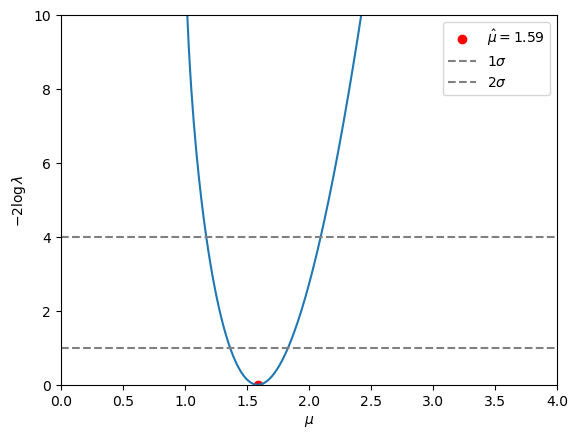

In [13]:
t_shape = -2 * torch.nansum(torch.tensor(events_obs_n)[:,None] * torch.log(r_sbi_over_bkg_mu), dim=0) 

plot_nll(mu_space, t_shape)

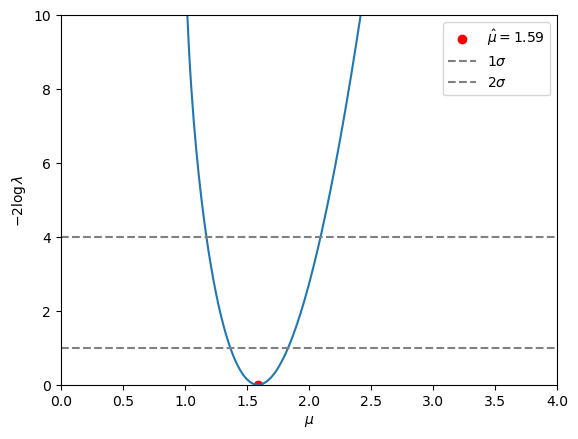

In [14]:
t = t_rate + t_shape
plot_nll(mu_space, t)

This helps smoothen out the curves but not much better results. Let's now try learning the weights of networks in the ensemble from data using $w_i f_i$ ensembles (arXiv:2506.00113). Strictly speaking, we should use a separate dataset to fit the ensemble weights, but for the purposes of this tutorial we'll just reuse the data used to train the ensemble members so that we don't have to download even more datasets.

We'll load those in again here.

In [15]:
from physics.simulation import mcfm

numerator_file = train_data_dir + 'sig_small.csv'
denominator_file = train_data_dir + 'bkg_small.csv'

# make sure the features are loaded in as observables (i.e. kinematics)
features = ["l1_pt", "l1_eta", "l1_phi", "l1_energy", "l2_pt", "l2_eta", "l2_phi", "l2_energy", "l3_pt", "l3_eta", "l3_phi", "l3_energy", "l4_pt", "l4_eta", "l4_phi", "l4_energy"]
events_n = mcfm.from_csv(file_path=numerator_file, kinematics=features)
events_d = mcfm.from_csv(file_path=denominator_file, kinematics=features)

n_evt_kinematics = scaler_sig_over_bkg.transform(events_n.kinematics[features].to_numpy())
d_evt_kinematics = scaler_sig_over_bkg.transform(events_d.kinematics[features].to_numpy())

n_weights = events_n.weights.to_numpy()
d_weights = events_d.weights.to_numpy()

Now, we'll compute each of the models' estimates of the log-likelihood on the numerator and denominator training datasets. It's also useful to allow for an overall constant shift in the log-likelihood, so we'll add in a fictitious constant model output in the log-likelihood outputs.

In [16]:
n_dl = DataLoader(TensorDataset(torch.tensor(n_evt_kinematics, dtype=torch.float32)), batch_size=1024) 
d_dl = DataLoader(TensorDataset(torch.tensor(d_evt_kinematics, dtype=torch.float32)), batch_size=1024) 

n_list = []
d_list = []
for model_sig_over_bkg in models_sig_over_bkg:
    n_list.append(torch.cat(trainer.predict(model_sig_over_bkg, n_dl)))
    d_list.append(torch.cat(trainer.predict(model_sig_over_bkg, d_dl)))

n_tensor = torch.stack(n_list, dim=0)
d_tensor = torch.stack(d_list, dim=0)
eps = 1e-7  # to avoid numerical issues with dividing by zero here
r_n = n_tensor/(1-n_tensor+eps)
r_d = d_tensor/(1-d_tensor+eps)

log_r_n = torch.ones((r_n.shape[0]+1, r_n.shape[1])) # +1 for the constant in the last row
log_r_n[:-1,:] = torch.log(r_n)

log_r_d = torch.ones((r_d.shape[0]+1, r_d.shape[1])) # +1 for the constant in the last row
log_r_d[:-1,:] = torch.log(r_d)

/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/common/software/trn016/python_envs/ml4fp2025 ...
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 216.65it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 150.54it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 218.47it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 220.06it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 224.85it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 217.96it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 226.97it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 224.09it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 147.95it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 250.70it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 221.37it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 223.33it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 227.98it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 219.73it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 219.08it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 143.69it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 219.09it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 208.42it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 224.76it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 220.02it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 225.14it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 229.67it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 148.12it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 227.20it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 222.80it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 244.29it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 232.53it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 232.42it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 206.20it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 152.46it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 218.65it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 225.66it/s]


Now we need a loss function to learn the weights. We'll follow 2506.00113 and use the symmetrized MLC loss, but just about any normal loss which is minimized by the objective function $\log r_\text{S}$ would work.

The loss we'll use is:
$$
\mathcal{L}_\text{symMLC} =  \sum_{\alpha \in n} [-w_i f_i(x_\alpha) + (\exp{-w_i f_i(x_\alpha)} - 1)] + \sum_{\alpha \in d} [w_i f_i(x_\alpha) + (\exp{w_i f_i(x_\alpha)} - 1)],
$$
which contains the MLC loss first introduced in 1806.02350 (with a different parameterization) with some added terms to restore the symmetry where you swap the numerator and denominator distributions while sending the log-likelihood to minus itself.

In [17]:
def symmetrized_mlc_loss(w, log_r_n, log_r_d, n_weights, d_weights):
    n_outs = w@log_r_n
    d_outs = w@log_r_d
    return -(n_outs*n_weights).mean() + (d_weights*(torch.exp(d_outs) - 1)).mean() + (d_weights*d_outs).mean() + (n_weights*(torch.exp(-n_outs) - 1)).mean()

We'll use the nifty full-batch optimization methods implemented in the package pytorch-minimize.

In [18]:
from torchmin import minimize
w0 = torch.ones((log_r_n.shape[0],), dtype=torch.float32) / (log_r_n.shape[0] - 1)  # uniform weights
w0[-1] = 0.0 # set the constant weight to zero initially
print("Initial value of the loss is", symmetrized_mlc_loss(w0, log_r_n, log_r_d, torch.tensor(n_weights), torch.tensor(d_weights)))
result = minimize(lambda w: symmetrized_mlc_loss(w, log_r_n, log_r_d, torch.tensor(n_weights), torch.tensor(d_weights)), w0,
                  method='l-bfgs', options={'max_iter': 1000, 'disp': True})
print("Final value of the loss is", result.fun)
w = result.x

Initial value of the loss is tensor(-8.2760e-05, dtype=torch.float64)
Optimization terminated successfully.
         Current function value: -0.000251
         Iterations: 7
         Function evaluations: 11
Final value of the loss is tensor(-0.0003, dtype=torch.float64)


Now, let's try going back to NSBI with these weights. Remember that we already computed all the model outputs on the observed data for the naive ensembles, so we don't need to recompute much here.

In [19]:
r_sig_over_bkg_wifi_ens = torch.exp(w[:-1]@torch.log(r_sig_over_bkg_tensor) + w[-1])  # the last term is the constant term which we added in
multiplier_sig = mu_space - torch.sqrt(mu_space)
multiplier_sbi = torch.sqrt(mu_space)
multiplier_bkg = 1 - torch.sqrt(mu_space)

r_sbi_over_bkg_mu = ( xs_sig_sm * multiplier_sig[None,:] * r_sig_over_bkg_wifi_ens[:,None] 
                     + xs_sbi_sm * multiplier_sbi[None,:] * r_sbi_over_bkg_sm[:,None] 
                     + xs_bkg_sm * multiplier_bkg[None,:] ) / (xs_sig_sm * mu_space + xs_int_sm * torch.sqrt(mu_space) + xs_bkg_sm)

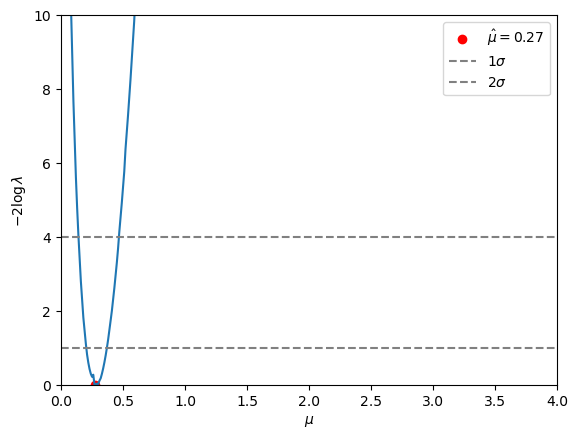

In [20]:
t_shape = -2 * torch.nansum(torch.tensor(events_obs_n)[:,None] * torch.log(r_sbi_over_bkg_mu), dim=0)

plot_nll(mu_space, t_shape)

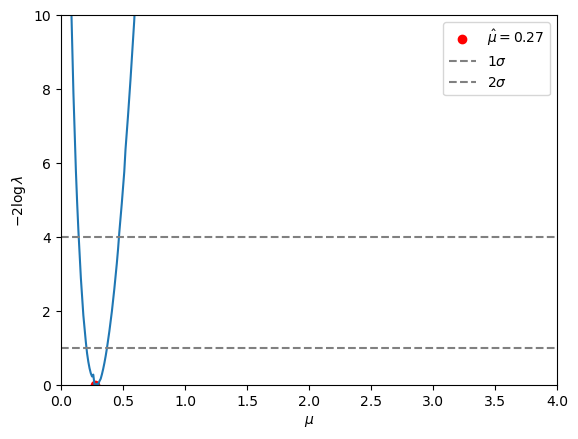

In [21]:
t = t_rate + t_shape
plot_nll(mu_space, t)

Let's quantitatively calculate the $1 \sigma$ confidence interval here by looking at where the test statistic is equal to $1$ greater than its minimum.

In [22]:
t_min_index = t.argmin()
lower_bd = -np.interp(-1, -t[:t_min_index], -mu_space[:t_min_index])
upper_bd = np.interp(1, t[t_min_index:], mu_space[t_min_index:])

Lower bound: 0.21, Upper bound: 0.37, stddev: 0.08


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_716592/2617636374.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(1.0, color='gray', linestyle='--', label='$1\sigma$')
/tmp/ipykernel_716592/2617636374.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(4.0, color='gray', linestyle='--', label='$2\sigma$')


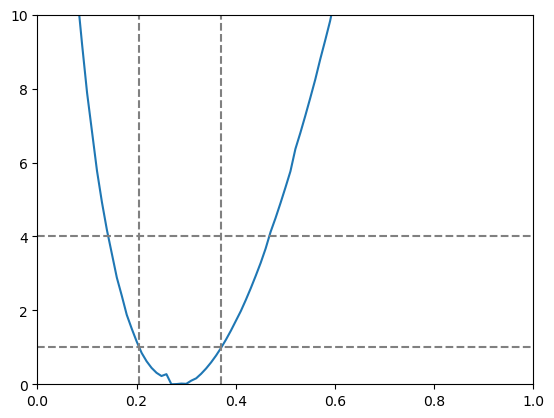

In [23]:
plt.plot(mu_space.cpu(), t.cpu())
plt.xlim(0, 1.0)
plt.ylim(0, 10)
plt.axhline(1.0, color='gray', linestyle='--', label='$1\sigma$')
plt.axhline(4.0, color='gray', linestyle='--', label='$2\sigma$')
plt.axvline(lower_bd, color='gray', linestyle='--', label=f'Lower bound: {lower_bd:.2f}')
plt.axvline(upper_bd, color='gray', linestyle='--', label=f'Upper bound: {upper_bd:.2f}')
print(f"Lower bound: {lower_bd:.2f}, Upper bound: {upper_bd:.2f}, stddev: {(upper_bd - lower_bd)/2:.2f}")

We can see that this has dramatically shifted us in the right direction; we went from excluding the result of our previous inference by more than $5 \sigma$ to agreeing with it, while using much less data to train $r_\text{S}$.

However, let's look a gift horse in the mouth: we used way fewer events to train $r_\text{S}$, so one might wonder if it's fishy that our uncertainty on $\mu$ is this small. After all, there's certainly a contribution from the fact that $r_\text{S}$ is estimated rather than known a priori, and we've totally ignored this! Are our confidence intervals trustworthy?

This is essentially the problem that $w_i f_i$ ensembles are meant to solve, by quantifying this contribution to the uncertainty. They aren't magic, and these uncertainties are only statistically rigorous under stringent assumptions, but they're certainly better than ignoring it entirely.

The first thing we'll need to do is to estimate the uncertainties in the $w_i$. Asymptotically (i.e. when we fit the $w_i$ to lots of data), the best fit $w_i$ (which we'll call $\hat{w}_i$) are approximately normally distributed, and their covariance matrix $C_{ij}$ can be estimated as:

$$
C_{ij} \approx V^{ik} U_{kl} V^{lj},
$$

with Einstein summation convention, $V^{ik}$ being the $ik$ component of the matrix inverse of the second derivative matrix of the symmetrized MLC loss, and $U_{kl}$ being the $kl$ component of the empirical covariance matrix of the score (i.e. first derivative of the symmetrized MLC loss).

We'll use double precision arithmetic here, since some of the matrix inversions and multiplications can get a bit dicey otherwise.

In [24]:
def symmetrized_mlc_loss(w, log_r_n, log_r_d, n_weights, d_weights):
    n_outs = w@log_r_n
    d_outs = w@log_r_d
    return -(n_outs*n_weights).mean() + (d_weights*(torch.exp(d_outs) - 1)).mean() + (d_weights*d_outs).mean() + (n_weights*(torch.exp(-n_outs) - 1)).mean()

def symmetrized_mlc_hessian(w, log_r_n, log_r_d, n_weights, d_weights):
    n_outs = w@log_r_n
    d_outs = w@log_r_d
    return (torch.einsum('ia, ja->ija', log_r_d, log_r_d) * torch.exp(d_outs)*d_weights + torch.einsum('ia, ja->ija', log_r_n, log_r_n) * torch.exp(-n_outs)*n_weights).sum(-1)

def symmetrized_mlc_grad_n(w, log_r_n, n_weights):
    n_outs = w@log_r_n
    return (-log_r_n - torch.exp(-n_outs) * log_r_n)*n_weights

def symmetrized_mlc_grad_d(w, log_r_d, d_weights):
    d_outs = w@log_r_d
    return (log_r_d + torch.exp(d_outs) * log_r_d)*d_weights

v_mat = torch.linalg.inv(symmetrized_mlc_hessian(w, log_r_n, log_r_d, n_weights, d_weights).double())
score_var_n = (symmetrized_mlc_grad_n(w, log_r_n, n_weights)@symmetrized_mlc_grad_n(w, log_r_n, n_weights).T)
score_var_d = (symmetrized_mlc_grad_d(w, log_r_d, d_weights)@symmetrized_mlc_grad_d(w, log_r_d, d_weights).T)
score_var = score_var_n + score_var_d
cov_mat = (v_mat@score_var.double()@v_mat).float()

/tmp/ipykernel_716592/1459765845.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (torch.einsum('ia, ja->ija', log_r_d, log_r_d) * torch.exp(d_outs)*d_weights + torch.einsum('ia, ja->ija', log_r_n, log_r_n) * torch.exp(-n_outs)*n_weights).sum(-1)
/tmp/ipykernel_716592/1459765845.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (-log_r_n - torch.exp(-n_outs) * log_r_n)*n_weights
/tmp/ipykernel_716592/1459765845.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (log_r_d + torch.exp(d_outs) * log_r_d)*d_weights


Now, we can propagate these uncertainties to our inference for $\mu$ by modifying the test statistic, as described in Appendix B of 2506.00113. The upshot: we need the second derivative matrix of the likelihood with respect to $\mu$ and the $w_i$ evaluated at the best fit values of these parameters. We'll call the second derivative of the likelihood with respect to $\mu$ $(\sigma^2_\text{MLE})^{-1}$, since this is the naive estimate for the resolution on $\mu$ ignoring uncertainties in $r_\text{S}$, and the mixed second derivatives we'll denote $A_i$. We won't need the other, $w_i - w_j$, block of the Hessian.

In [25]:
def likelihood(mu, w):
    r_sig_over_bkg_wifi_ens = torch.exp(w[:-1]@torch.log(r_sig_over_bkg_tensor) + w[-1])  # the last term is the constant term which we added in
    multiplier_sig = mu - mu**0.5
    multiplier_sbi = mu**0.5
    multiplier_bkg = 1 - mu**0.5
    r_sbi_over_bkg_mu = ( xs_sig_sm * multiplier_sig * r_sig_over_bkg_wifi_ens[:,None] + xs_sbi_sm * multiplier_sbi * r_sbi_over_bkg_sm[:,None] + xs_bkg_sm * multiplier_bkg ) / (xs_sig_sm * mu + xs_int_sm * mu**0.5 + xs_bkg_sm)
    return torch.nansum(torch.tensor(events_obs_n)[:,None] * torch.log(r_sbi_over_bkg_mu), dim=0)

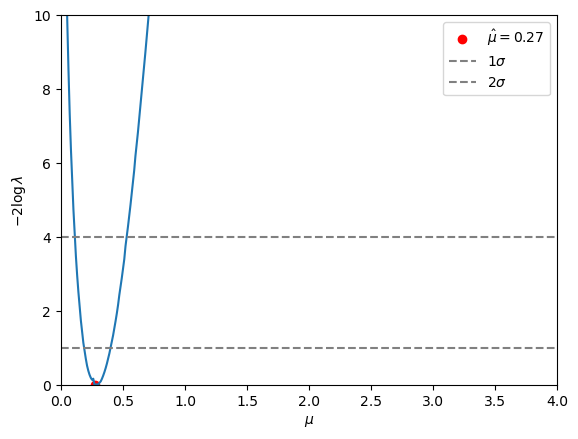

In [26]:
mu_hat = mu_space[t_shape.argmin()]
sigma_squared_mle = (-1/torch.func.hessian(likelihood)(mu_hat, w))
ai = torch.func.jacfwd(torch.func.jacrev(likelihood, argnums=0), argnums=1)(mu_hat, w)

test_statistic_adjustment = 1+sigma_squared_mle*(ai@cov_mat@ai.T)[0,0]
t = t_rate + t_shape/test_statistic_adjustment
plot_nll(mu_space, t)

In [27]:
t_min_index = t.argmin()
lower_bd = -np.interp(-1, -t[:t_min_index], -mu_space[:t_min_index])
upper_bd = np.interp(1, t[t_min_index:], mu_space[t_min_index:])

Lower bound: 0.19, Upper bound: 0.40, stddev: 0.11


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_716592/2617636374.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(1.0, color='gray', linestyle='--', label='$1\sigma$')
/tmp/ipykernel_716592/2617636374.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(4.0, color='gray', linestyle='--', label='$2\sigma$')


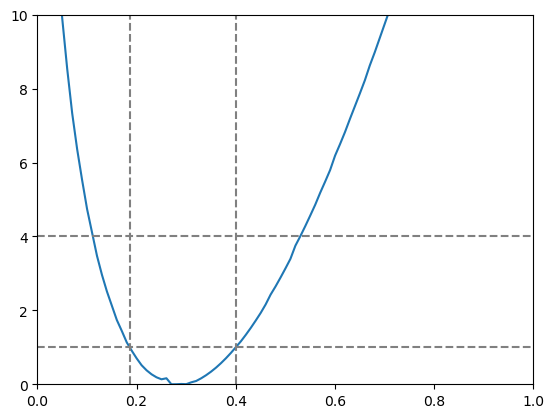

In [28]:
plt.plot(mu_space.cpu(), t.cpu())
plt.xlim(0, 1.0)
plt.ylim(0, 10)
plt.axhline(1.0, color='gray', linestyle='--', label='$1\sigma$')
plt.axhline(4.0, color='gray', linestyle='--', label='$2\sigma$')
plt.axvline(lower_bd, color='gray', linestyle='--', label=f'Lower bound: {lower_bd:.2f}')
plt.axvline(upper_bd, color='gray', linestyle='--', label=f'Upper bound: {upper_bd:.2f}')
print(f"Lower bound: {lower_bd:.2f}, Upper bound: {upper_bd:.2f}, stddev: {(upper_bd - lower_bd)/2:.2f}")

We can see that the uncertainty in our estimate of $r_\text{S}$ increased our total uncertainty on $\mu$ by almost $50$%! If we were to ignore this, we certainly wouldn't get confidence intervals that satisfied the advertised coverage properties.

In summary, in this tutorial we saw (by using a small subset of our training data) that bad estimates of likelihood ratios can totally compromise the validity of NSBI. We saw that naively ensembling can help a bit, but that you can improve your estimates a lot more by using $w_i f_i$ ensembles to learn ensemble weights from data. This also gives you a way to quantify the remaining uncertainties from this density ratio estimation, which is necessary in general for confidence intervals to live up to their advertised coverage.